## Hash Algorithm and Image Generator

In [509]:
import random


In [510]:
from config import COLLECTION_DIR

# cat_path = imgs_path / "cat"
imgs_path = COLLECTION_DIR
robot_path = imgs_path / "robot"

robot_path


PosixPath('/windows10/Users/hamng/Desktop/projects/delicacy/images/robot')

### collection and image generator

In [511]:
from delicacy.igen.collection import Collection
from delicacy.igen.igen import ImageGenerator


In [512]:
# cat_collection = Collection("Cat", cat_path)
robot_collection = Collection("Robot", robot_path)
robot_collection


Collection(name='Robot', path=PosixPath('/windows10/Users/hamng/Desktop/projects/delicacy/images/robot'), layer_names=('000#Body', '001#Face', '002#Mouth', '003#Eyes', '004#Accessory'))

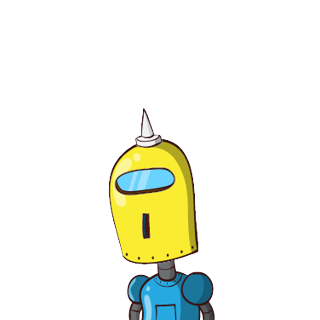

In [513]:
img_gen = ImageGenerator(robot_collection)
phrase = "elonmusk"
width = height = 320
my_img = img_gen.generate(phrase, size=(width, height))
my_img


In [514]:
img_gen._hash("test")


BitArray('0x9ece086e9bac491fac5c1d1046ca11d737b92a2b2ebd93f005d7b710110c0a678288166e7fbe796883a4f2e9b3ca9f484f521d0ce464345cc1aec96779149c14')

## Generative Art for Background

### utils

In [515]:
from lxml import etree
from lxml.etree import Element

from delicacy.svglib.utils.utils import (
    eprint,
    get_canvas,
    svg2img,
    canvas2img,
    linspace,
)


In [516]:
canvas = get_canvas(512, 512)

eprint(canvas)
print(canvas.attrib)


<svg xmlns:xlink="http://www.w3.org/1999/xlink" width="512" height="512" xmlns="http://www.w3.org/2000/svg"/>

{'width': '512', 'height': '512', 'xmlns': 'http://www.w3.org/2000/svg'}


### style & transform

In [517]:
from delicacy.svglib.elements.peripheral.style import Style, Stroke, Fill
from delicacy.svglib.elements.peripheral.transform import Transform

transform = Transform().translate(5).skewX(4)
stroke, fill = Stroke(), Fill()

print(stroke)
print(fill)
print(transform())


stroke: black; stroke-opacity: 1; stroke-width: 1;
fill: black; fill-opacity: 1;
translate(5,0) skewX(4)


### elements

In [518]:
from delicacy.svglib.elements.element import (
    SVGElement,
    ExtendedElement,
    svg_define,
)
from delicacy.svglib.elements.element import wraps, defs, group, symbol


In [519]:
style_str = "stroke: black;stroke-opacity: 1;\nfill-opacity: 1;stroke-width: 1;fill: black;"
ExtendedElement.extract_styles(style_str)


{'stroke': 'black',
 'stroke-opacity': '1',
 'fill-opacity': '1',
 'stroke-width': '1',
 'fill': 'black'}

### shape

In [520]:
from delicacy.svglib.elements.shapes import (
    Line,
    Polygon,
    Circle,
    Rectangle,
    Path,
    XShape,
    ETriangle,
)

line = Line.make_line(0, 100, 200, 500)

line.add_transform(Transform().translate(4).rotate(45).scale(3))
line.apply_styles(Stroke(), Fill())

eprint(line.base)
line.styles


<line x1="0" y1="100" x2="200" y2="500" transform="translate(4,0) rotate(45) scale(3,3)" style="stroke: black; stroke-opacity: 1; stroke-width: 1; fill: black; fill-opacity: 1;"/>



{'stroke': 'black',
 'stroke-opacity': '1',
 'stroke-width': '1',
 'fill': 'black',
 'fill-opacity': '1'}

### color & palette

In [521]:
from delicacy.svglib.colors.hsv import HSVColor
from delicacy.svglib.colors.palette import PaletteGenerator
from delicacy.svglib.colors.palette import (
    analogous,
    monochromatic,
    shade,
    tint,
    complementary,
    triad,
    square,
    jewel,
    pastel,
    earth,
    neon,
    palettes,
)


### gradient 

In [522]:
from delicacy.svglib.elements.gradient import (
    BaseGradient,
    LinearGradient,
    RadialGradient,
    create_gradient,
)

rg = create_gradient(
    RadialGradient, colors=["#e63946", "#e0aaff", "#240046", "#1d3557"]
)

print(defs(rg))


<defs>
  <radialGradient cx="50%" cy="50%" fx="50%" fy="50%" id="radialGradient" r="55%" spreadMethod="pad">
    <stop offset="0%" stop-color="#e63946" stop-opacity="1.0"/>
    <stop offset="33%" stop-color="#e0aaff" stop-opacity="1.0"/>
    <stop offset="67%" stop-color="#240046" stop-opacity="1.0"/>
    <stop offset="100%" stop-color="#1d3557" stop-opacity="1.0"/>
  </radialGradient>
</defs>



In [523]:
def get_reference(element):
    return f"url(#{element.id})"


get_reference(rg)


'url(#radialGradient)'

## use

In [524]:
from delicacy.svglib.elements.use import Use

use = Use("something")
str(use)


'<use href="#something" x="0" y="0"/>\n'

In [525]:
colors = ["#3a86ff", "#ff006e", "#ffbe0b", "#0a9396"]

pastel
CPU times: user 101 ms, sys: 3.15 ms, total: 104 ms
Wall time: 102 ms


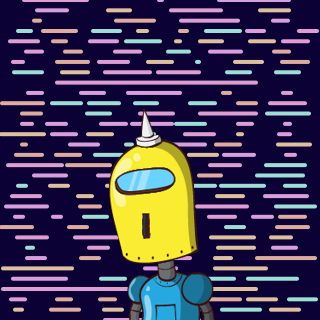

In [544]:
%%time

from delicacy.excite import exaid

palette_func = random.choice([tint, shade, analogous, monochromatic, neon, pastel, jewel, triad, square])
print(palette_func.__name__)

canvas = exaid(width, height, palette_func=palette_func)
bg_img = canvas2img(canvas, bg_color="#0c0135")
bg_img.paste(my_img, (0, 0), my_img)
bg_img

monochromatic
CPU times: user 260 ms, sys: 2.92 ms, total: 263 ms
Wall time: 262 ms


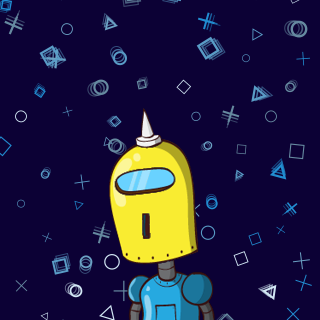

In [551]:
%%time
from delicacy.excite import genm

palette_func = random.choice([tint, shade, analogous, monochromatic, neon, pastel, jewel, triad, square])
print(palette_func.__name__)

canvas = genm(width, height, palette_func=palette_func)
bg_img = canvas2img(canvas, bg_color="#0c0135")
bg_img.paste(my_img, (0, 0), my_img)
bg_img


shade
CPU times: user 82.3 ms, sys: 3.27 ms, total: 85.5 ms
Wall time: 84.3 ms


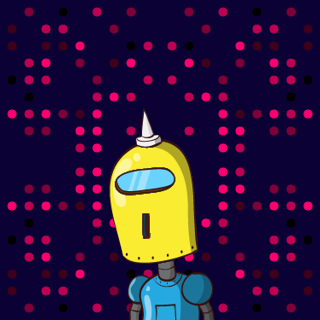

In [553]:
%%time
from delicacy.excite import paradx

palette_func = random.choice([tint, shade, analogous, monochromatic, neon, pastel, jewel, triad, square])
print(palette_func.__name__)

canvas = paradx(width, palette_func=palette_func)
bg_img = canvas2img(canvas, bg_color="#0c0135")
bg_img.paste(my_img, (0, 0), my_img)
bg_img
